# **Inverse PINN for Burgers' Equation**

##  **Objective**

Today, we will use **Physics-Informed Neural Networks (PINNs)** to solve an **inverse problem** for the **1D Burgers' equation**:

$\partial u/\partial t + u \, \partial u/ \partial x = \nu \, \partial^2 u/\partial x^2$, where $x \in [-1,1]$ and $t \in [0,1]$.



In the inverse setup, we rewrite it as following:

$\partial u/\partial t + \lambda_1u \, \partial u/ \partial x = \lambda_2 \, \partial^2 u/\partial x^2$


where, $\lambda_1 \approx 1$ and $\lambda_2 = \nu$
###  **Problem Setup**:

- **Initial condition**: $u(x, 0) = -\sin(\pi x)$  
- **Boundary conditions**: $u(-1, t) = u(1, t) = 0$

---

Our goal is to:
- **Predict the solution** $u(x,t)$ across the space–time domain.
- **Identify the unknown parameter** $\nu$ (or $\lambda_1$, $\lambda_2$ in general form) using a few scattered measurements of $u$.

This is an **inverse problem**, where we recover physical parameters from sparse data and PDE structure.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
project_path = '/content/drive/MyDrive/Colab_Notebooks/PINNs/Burgers_Equation/'
os.chdir(project_path)

import warnings
warnings.filterwarnings('ignore')

Mounted at /content/drive


In [2]:
## Imports

import numpy as np
import torch                            # PyTorch deep learning library
import torch.nn as nn                  # For defining neural network layers and architectures
from torch import autograd             # For automatic differentiation
import matplotlib.pyplot as plt         # Visualization library for plotting results

##  **Device Setup**

We check whether a GPU (CUDA) is available and assign it as the computation device.  
A fixed random seed is also used to ensure reproducibility of the training results.

In [3]:
## Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)
if device.type == 'cuda':
    torch.cuda.manual_seed_all(42)

##  **Step 1: Load the Reference Data**

We load the numerical solution of the Burgers' equation from the provided `.npz` file. This dataset contains:
- `x`: 256 spatial points
- `t`: 100 time steps
- `usol`: 2D solution grid for \( u(x,t) \)

This data will be used to:
- Create the training set (a few observed values of \( u \))
- Build the collocation points for PDE residual loss

In [5]:
## Load data from .npz
data = np.load("Burgers.npz")
x = data['x']         # (256, 1)
t = data['t']         # (100, 1)
usol = data['usol']   # (256, 100)

print(f"x shape: {x.shape}, t shape: {t.shape}, u shape: {usol.shape}")

x shape: (256, 1), t shape: (100, 1), u shape: (256, 100)


## **Step 2: Create the Spatiotemporal Mesh**

We use `np.meshgrid` to construct the 2D mesh over \((x,t)\) space and flatten it for use in the neural network. This gives:
- `X_star`: flattened \((x, t)\) coordinate pairs
- `u_star`: corresponding ground truth \( u(x,t) \)

These represent the **full domain**, from which we’ll sample:
- A small subset as training data
- A large set of collocation points for physics-based loss

In [6]:
## Create the meshgrid
X, T = np.meshgrid(x.flatten(), t.flatten())
X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))  # (25600, 2)
u_star = usol.T.flatten()[:, None]  # (25600, 1)

In [7]:
print(f"X_star shape: {X_star.shape}, u_star shape: {u_star.shape}")

X_star shape: (25600, 2), u_star shape: (25600, 1)


##  **Step 3: Prepare Training Data**

We randomly select some points:
- `N_u = 100` data points from \( u(x,t) \) as the **observed training data**
- `N_f = 10000` collocation points from the full domain to enforce the **PDE residual**

All selected points are then converted into PyTorch tensors and moved to the target device (CPU/GPU).

In [8]:
## Sample training and collocation data

# Number of supervised training points (i.e., we know the values of u)
N_u = 100

# Number of collocation points (i.e., we enforce the PDE residual via physics loss)
N_f = 10000

# Sample N_u random indices from the full domain
idx_u = np.random.choice(X_star.shape[0], N_u, replace=False)     # These are the (x, t) locations where we know the value of u
X_u_train = X_star[idx_u, :]   # Coordinates of known u values
u_train = u_star[idx_u, :]     # Corresponding u values

# Sample N_f random indices to generate collocation points
idx_f = np.random.choice(X_star.shape[0], N_f, replace=False)        # These points will be used to minimize the residual of the PDE
X_f_train = X_star[idx_f, :]   # Coordinates used to compute f(x,t) ≈ 0

In [9]:
# Convert to torch tensors
X_u_train = torch.tensor(X_u_train, dtype=torch.float32, requires_grad=True).to(device)
u_train = torch.tensor(u_train, dtype=torch.float32).to(device)
X_f_train = torch.tensor(X_f_train, dtype=torch.float32, requires_grad=True).to(device)

# **Step 4: Define Neural Network**

In [10]:
## Define the neural network architecture
class DNN(nn.Module):
    def __init__(self):
        super().__init__()

        # Input layer: takes 2 inputs (x and t)
        self.fc1 = nn.Linear(2, 20)

        # Hidden layers: each has 20 neurons and uses Tanh activation
        self.fc2 = nn.Linear(20, 20)
        self.fc3 = nn.Linear(20, 20)
        self.fc4 = nn.Linear(20, 20)

        # Output layer: predicts a single scalar u(x,t)
        self.out = nn.Linear(20, 1)

        # Activation function used between all layers (except the output)
        self.activation = nn.Tanh()

        # Xavier initialization for all layers
        for layer in [self.fc1, self.fc2, self.fc3, self.fc4, self.out]:
            nn.init.xavier_normal_(layer.weight)  # good for tanh/sigmoid
            nn.init.zeros_(layer.bias)            # bias starts at 0

    def forward(self, x):
        # Pass input through each layer with activation
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.activation(self.fc4(x))

        # Final output (no activation here)
        return self.out(x)

## **Step 5: Define the PINN Architecture**

The PINN model consists of:
- A **feedforward neural network (DNN)** that approximates the solution $u(x, t)$
- A **residual network** that enforces the governing PDE using automatic differentiation
- Two **trainable parameters**, $\lambda_1$ (convection coefficient) and $\lambda_2$ (diffusion coefficient)

The total loss function is:

$\mathcal{L}_L = \text{MSE}_u + \text{MSE}_f$

where:
- $\text{MSE}_u$ is the **data loss** (difference between predicted and observed $u$ at a few known points)
- $\text{MSE}_f$ is the **physics loss** (PDE residual, which should be close to 0)

This combination allows the network to both match known data and satisfy the underlying physical law.

In [11]:
## Define PINN class
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        # Mean squared error loss for both data and physics
        self.loss_function = nn.MSELoss()
        self.iter = 0  # Counter to track training iterations

        # Inverse problem: lambda1 and lambda2 are unknown parameters we want to learn
        # They are set as trainable parameters
        self.lambda1 = nn.Parameter(torch.tensor([2.0], dtype=torch.float32, requires_grad=True).to(device))        # Initial guess
        self.lambda2 = nn.Parameter(torch.tensor([0.2], dtype=torch.float32, requires_grad=True).to(device))

        # Neural network that learns u(x, t)
        self.dnn = DNN().to(device)

    def net_u(self, x):
        """
        Forward pass through the neural network to get u(x, t).
        """
        return self.dnn(x)

    def net_f(self, x_f):
        """
        Compute the PDE residual f = u_t + λ1 * u * u_x - λ2 * u_xx.
        Uses automatic differentiation to compute derivatives.
        """
        u = self.dnn(x_f)

        # First-order gradients: [∂u/∂x, ∂u/∂t]
        grads = autograd.grad(u, x_f, torch.ones_like(u), create_graph=True)[0]
        u_x = grads[:, [0]]
        u_t = grads[:, [1]]

        # Second-order gradient: ∂²u/∂x²
        grads2 = autograd.grad(u_x, x_f, torch.ones_like(u_x), create_graph=True)[0]
        u_xx = grads2[:, [0]]

        # PDE residual
        f = u_t + self.lambda1 * u * u_x - self.lambda2 * u_xx
        return f

    def loss(self, X_u_train, u_train, X_f_train):
        """
        Total loss = data loss + physics loss
        """
        # Data loss (mean squared error on known u values)
        mse_u = self.loss_function(self.net_u(X_u_train), u_train)

        # Physics loss (mean squared error on PDE residual f ≈ 0)
        mse_f = self.loss_function(self.net_f(X_f_train), torch.zeros_like(X_f_train[:, [0]]))

        return mse_u + mse_f

    def closure(self, X_u_train, u_train, X_f_train, optimizer):
        # Computes the loss and its gradients
        optimizer.zero_grad()
        loss = self.loss(X_u_train, u_train, X_f_train)
        loss.backward()

        # Print training progress every 1000 iterations
        self.iter += 1
        if self.iter % 1000 == 0:
            print(f"Iter {self.iter:5d} | Loss: {loss.item():.4e} | λ₁: {self.lambda1.item():.4f} | λ₂: {self.lambda2.item():.4f}")
        return loss

## **Step 6: Train the PINN Model**

We train the model in **two stages** using different optimizers:

### **Stage 1: Adam Optimizer**
We start with the **Adam optimizer**, which is a fast and adaptive first-order optimizer.  
It helps to:
- Quickly reduce the total loss
- Explore the solution space effectively
- Handle noisy gradients during early training

However, Adam may not converge precisely and often stalls near a suboptimal solution.

---

###  **Stage 2: LBFGS Optimizer**
After pretraining with Adam, we switch to **L-BFGS**, a quasi-Newton optimizer.  
It is well-suited for:
- Achieving **high-precision convergence**
- Enforcing PDE residuals to be very close to zero
- Handling smooth, physics-informed loss surfaces

---

###  **Why We Use Both?**
| Optimizer | Role                     | Pros                               | Cons                          |
|-----------|--------------------------|------------------------------------|-------------------------------|
| Adam      | Pretraining              | Fast, adaptive, robust             | Low final precision           |
| LBFGS     | Fine-tuning              | Precise, curvature-aware           | Slow, sensitive to init       |

Using both is a standard practice in PINNs to combine **speed and accuracy** during training.

We monitor:
- Total loss
- Estimated parameters $\lambda_1$, $\lambda_2$

In [12]:
## Initialize the PINN model and optimizers

model = PINN()  # Contains both the neural net and trainable parameters λ₁, λ₂

for name, param in model.named_parameters():
    print(f"{name}: {param.shape}, requires_grad={param.requires_grad}")

# Adam optimizer — fast and robust for early training
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  # Learning rate = 0.001

print(" Training with Adam...")

for epoch in range(20000):
    model.closure(X_u_train, u_train, X_f_train, optimizer)     # We train for 20,000 epochs using Adam. This step quickly reduces the loss and provides a good initialization for LBFGS.

# Fine-tune with LBFGS optimizer
print("Fine-tuning with LBFGS...")

optimizer_LBFGS = torch.optim.LBFGS(
    model.parameters(),        # Optimize DNN weights (λ₁ and λ₂ are part of model)
    max_iter=50000,                # Maximum number of iterations (won't always reach this)
    tolerance_grad=1e-10,          # Stop early if gradient norm is very small
    tolerance_change=1e-10,        # Stop if loss changes by very little
    history_size=50,               # How many previous steps to store for Hessian approximation
    line_search_fn="strong_wolfe"  # Line search method to find optimal step size or decides how far to move along a gradient direction
)

# Begin optimization using LBFGS
# The .step() function will internally call the closure multiple times and stop early if converged.
optimizer_LBFGS.step(lambda: model.closure(X_u_train, u_train, X_f_train, optimizer_LBFGS))

lambda1: torch.Size([1]), requires_grad=True
lambda2: torch.Size([1]), requires_grad=True
dnn.fc1.weight: torch.Size([20, 2]), requires_grad=True
dnn.fc1.bias: torch.Size([20]), requires_grad=True
dnn.fc2.weight: torch.Size([20, 20]), requires_grad=True
dnn.fc2.bias: torch.Size([20]), requires_grad=True
dnn.fc3.weight: torch.Size([20, 20]), requires_grad=True
dnn.fc3.bias: torch.Size([20]), requires_grad=True
dnn.fc4.weight: torch.Size([20, 20]), requires_grad=True
dnn.fc4.bias: torch.Size([20]), requires_grad=True
dnn.out.weight: torch.Size([1, 20]), requires_grad=True
dnn.out.bias: torch.Size([1]), requires_grad=True
 Training with Adam...
Iter  1000 | Loss: 3.3754e-01 | λ₁: 2.0000 | λ₂: 0.2000
Iter  2000 | Loss: 3.3754e-01 | λ₁: 2.0000 | λ₂: 0.2000
Iter  3000 | Loss: 3.3754e-01 | λ₁: 2.0000 | λ₂: 0.2000
Iter  4000 | Loss: 3.3754e-01 | λ₁: 2.0000 | λ₂: 0.2000
Iter  5000 | Loss: 3.3754e-01 | λ₁: 2.0000 | λ₂: 0.2000
Iter  6000 | Loss: 3.3754e-01 | λ₁: 2.0000 | λ₂: 0.2000
Iter  7000 | L

tensor(0.3375, device='cuda:0', grad_fn=<AddBackward0>)

## **Step 7: Predict, Visualize and Report**

After training, we evaluate the trained PINN model on the **entire space-time domain** $X_{\text{star}}$ to predict the solution $u(x, t)$.

We then visualize the predicted solution as a color map to observe how well the network has learned the behavior of the Burgers' equation.

Finally, we report the **learned parameters**:
- $\lambda_1$: the **convection coefficient**
- $\lambda_2$: the **diffusion coefficient**

These are compared against the true values used to generate the synthetic data.  
This helps assess how successfully the model has solved the **inverse problem** — i.e., recovering hidden physical parameters from limited data.

In [13]:
## Predict full field using trained PINN
# Convert full (x, t) domain to a PyTorch tensor and move to device
X_star_tensor = torch.tensor(X_star, dtype=torch.float32).to(device)

# Predict u(x,t) across the full domain
u_pred = model.dnn(X_star_tensor).detach().cpu().numpy()  # shape: (25600, 1)
u_pred = u_pred.reshape(100, 256)  # reshape to match (t, x) = (100, 256)

# Also reshape reference (true) solution for comparison
u_true = usol.T  # shape is already (100, 256)

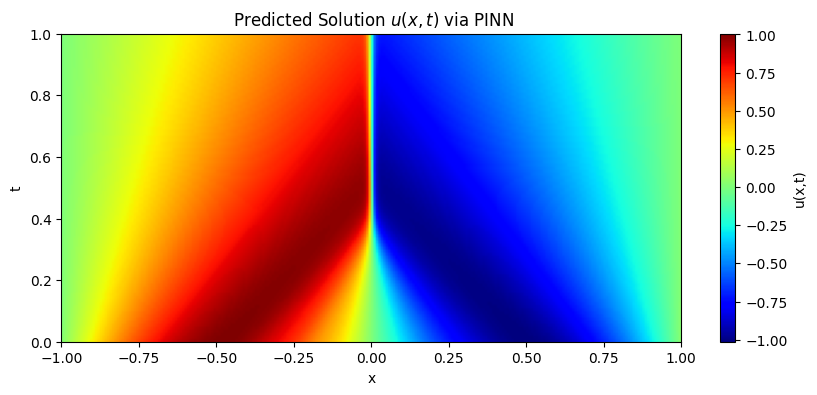

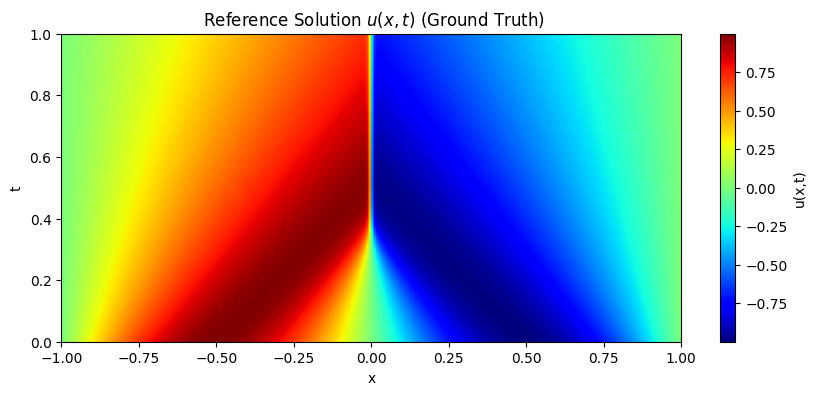

In [14]:
# Plot predicted solution

plt.figure(figsize=(10, 4))
plt.imshow(u_pred, extent=[-1, 1, 0, 1], aspect='auto', cmap='jet', origin='lower')
plt.colorbar(label="u(x,t)")
plt.title(" Predicted Solution $u(x,t)$ via PINN")
plt.xlabel("x")
plt.ylabel("t")
plt.show()

# Plot reference (true) solution

plt.figure(figsize=(10, 4))
plt.imshow(u_true, extent=[-1, 1, 0, 1], aspect='auto', cmap='jet', origin='lower')
plt.colorbar(label="u(x,t)")
plt.title(" Reference Solution $u(x,t)$ (Ground Truth)")
plt.xlabel("x")
plt.ylabel("t")
plt.show()

In [15]:
# Learned PDE parameters (from inverse problem)
print(f"\n Learned λ₁ (convection): {model.lambda1.item():.6f}")
print(f" Learned λ₂ (diffusion):  {model.lambda2.item():.6f}")

# True values
print(f"\n True λ₁: 1  (for comparison)")
print(f" True λ₂: {0.01 / np.pi:.6f}  (for comparison)")


 Learned λ₁ (convection): 0.967457
 Learned λ₂ (diffusion):  0.004906


# **Can We Still Predict the Same Unknown Parameters If the Data Is Noisy?**

In real-world scenarios, measurements are rarely perfect — they often contain **noise** due to sensors, environment, or system variability.

So the question is:
> Can our Physics-Informed Neural Network still **recover the correct parameters** (like $\nu$, $\lambda_1$, or $\lambda_2$) even when the training data is noisy?

This leads us to explore:
- How robust the PINN framework is to **noisy observations**
- Whether physics-based regularization helps in **denoising and identifying** the correct dynamics

## **Step 1: Add Gaussian noise**

In [16]:
noise_level = 0.05  # 5% noise

u_train_np = u_train.cpu().numpy()      #Convert the clean training data to a NumPy array (if on GPU, move to CPU first)

noise = noise_level * np.std(u_train_np) * np.random.randn(*u_train_np.shape)
u_train_noisy = u_train_np + noise

# Convert to tensor
u_train_noisy = torch.tensor(u_train_noisy, dtype=torch.float32).to(device)

## **Step 2: Initialize model**

In [17]:
model = PINN().to(device)

## **Step 3: Train with Adam**

In [18]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
for epoch in range(10000):
    model.closure(X_u_train, u_train_noisy, X_f_train, optimizer)

Iter  1000 | Loss: 1.3154e+00 | λ₁: 2.0000 | λ₂: 0.2000
Iter  2000 | Loss: 1.3154e+00 | λ₁: 2.0000 | λ₂: 0.2000
Iter  3000 | Loss: 1.3154e+00 | λ₁: 2.0000 | λ₂: 0.2000
Iter  4000 | Loss: 1.3154e+00 | λ₁: 2.0000 | λ₂: 0.2000
Iter  5000 | Loss: 1.3154e+00 | λ₁: 2.0000 | λ₂: 0.2000
Iter  6000 | Loss: 1.3154e+00 | λ₁: 2.0000 | λ₂: 0.2000
Iter  7000 | Loss: 1.3154e+00 | λ₁: 2.0000 | λ₂: 0.2000
Iter  8000 | Loss: 1.3154e+00 | λ₁: 2.0000 | λ₂: 0.2000
Iter  9000 | Loss: 1.3154e+00 | λ₁: 2.0000 | λ₂: 0.2000
Iter 10000 | Loss: 1.3154e+00 | λ₁: 2.0000 | λ₂: 0.2000


## **Step 4: Fine-tune with LBFGS**

In [19]:
print("Fine-tuning with LBFGS...")

optimizer_LBFGS = torch.optim.LBFGS(
    model.parameters(),
    max_iter=50000,
    tolerance_grad=1e-10,
    tolerance_change=1e-10,
    history_size=50,
    line_search_fn="strong_wolfe"
)

optimizer_LBFGS.step(lambda: model.closure(X_u_train, u_train_noisy, X_f_train, optimizer_LBFGS))

Fine-tuning with LBFGS...
Iter 11000 | Loss: 4.4276e-03 | λ₁: 0.7128 | λ₂: 0.0069
Iter 12000 | Loss: 2.2371e-03 | λ₁: 0.8688 | λ₂: 0.0073
Iter 13000 | Loss: 1.4012e-03 | λ₁: 0.8962 | λ₂: 0.0064
Iter 14000 | Loss: 1.1347e-03 | λ₁: 0.9164 | λ₂: 0.0056
Iter 15000 | Loss: 1.0157e-03 | λ₁: 0.9231 | λ₂: 0.0054


tensor(1.3154, device='cuda:0', grad_fn=<AddBackward0>)

## **Step 5: Report learned parameters**

In [20]:
lambda1_learned = model.lambda1.item()
lambda2_learned = model.lambda2.item()

print("\n Training completed with noisy data.")
print(f" Learned λ₁ (convection): {lambda1_learned:.6f}")
print(f" Learned λ₂ (diffusion):  {lambda2_learned:.6f}")

print(f"\n True λ₁: 1  (for comparison)")
print(f" True λ₂: {0.01 / np.pi:.6f}  (for comparison)")


 Training completed with noisy data.
 Learned λ₁ (convection): 0.927154
 Learned λ₂ (diffusion):  0.005321
 True λ₂: 0.003183  (for comparison)
